## TL;DR

Scatter shows some grouping of samples under One-vs-All scenario (e.g. worm vs other, etc)

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import QuantileTransformer
from sklearn.pipeline import make_pipeline
from pandas.plotting import parallel_coordinates

data_folder = '../data/csv_data/'
extension = '.csv.gz'
build_path = lambda x: data_folder + x + extension

df = pd.read_csv(build_path('malwr_behav_categories_bigrams')).set_index('link')
file_info = pd.read_csv(build_path('malwr_file_info'), dtype=str).set_index('link')[['md5']]
file_info.drop_duplicates(keep='last', inplace=True)
df = df[df.index.isin(file_info.index)]
goodware = pd.read_csv(build_path('goodware_real'), dtype=str).link
# malware_labeled = pd.read_csv(build_path('malware_labeled'), dtype=str).set_index('md5')
malware_labeled = pd.read_csv(build_path('malware_labeled'), dtype=str).set_index('link')

goodware = goodware[~goodware.isin(malware_labeled)]
malware_labeled = malware_labeled[~malware_labeled.isin(goodware)]

# malware_detailed = file_info.join(malware_labeled, on='md5', how='inner').drop('md5', axis=1)
malware_detailed = malware_labeled

malwr_vendors_filtered = pd.read_csv(build_path('malwr_vendors_filtered'), dtype=str).set_index('link')
score = malwr_vendors_filtered.replace('Clean', np.nan).count(axis=1)
ambiguous_score = score[(score < 5) & (score > 0)].index
malware_detailed = malware_detailed[~malware_detailed.index.isin(ambiguous_score)]

df = df[(df.index.isin(goodware)) | (df.index.isin(malware_detailed.index))]

df_stats = df.describe()

In [8]:
display(df_stats)

('anomaly', 'anomaly')  ('anomaly', 'device')  \
count             7975.000000              12.000000   
mean               178.125517               1.416667   
std                132.258344               0.792961   
min                  1.000000               1.000000   
25%                150.000000               1.000000   
50%                152.000000               1.000000   
75%                165.000000               1.250000   
max               1826.000000               3.000000   

       ('anomaly', 'filesystem')  ('anomaly', 'hooking')  ('anomaly', 'misc')  \
count                 344.000000                     7.0           226.000000   
mean                    2.776163                     1.0             1.017699   
std                     3.503336                     0.0             0.162333   
min                     1.000000                     1.0             1.000000   
25%                     1.000000                     1.0             1.000000   
50%                     1.000000                     1.0             1.000000   
75%                     2.000000                     1.0             1.000000   
max                    19.000000                     1.0             3.000000   

       ('anomaly', 'network')  ('anomaly', 'process')  \
count              189.000000              489.000000   
mean                 1.026455                1.660532   
std                  0.217184                2.809399   
min                  1.000000                1.000000   
25%                  1.000000                1.000000   
50%                  1.000000                1.000000   
75%                  1.000000                1.000000   
max                  3.000000               42.000000   

       ('anomaly', 'registry')  ('anomaly', 'services')  \
count               360.000000                88.000000   
mean                  1.583333                 1.011364   
std                   1.643337                 0.106600   
min                   1.000000                 1.000000   
25%                   1.000000                 1.000000   
50%                   1.000000                 1.000000   
75%                   1.000000                 1.000000   
max                  20.000000                 2.000000   

       ('anomaly', 'socket')           ...            ('windows', 'misc')  \
count              77.000000           ...                   42642.000000   
mean                1.038961           ...                      61.512101   
std                 0.194771           ...                     699.776951   
min                 1.000000           ...                       1.000000   
25%                 1.000000           ...                       1.000000   
50%                 1.000000           ...                       1.000000   
75%                 1.000000           ...                       1.000000   
max                 2.000000           ...                   21449.000000   

       ('windows', 'network')  ('windows', 'process')  \
count              634.000000             7203.000000   
mean                10.252366              354.780925   
std                 98.441694             1916.417248   
min                  1.000000                1.000000   
25%                  1.000000                1.000000   
50%                  1.000000                1.000000   
75%                  2.000000                2.000000   
max               2065.000000            39965.000000   

       ('windows', 'registry')  ('windows', 'services')  \
count             16295.000000              1230.000000   
mean                 10.176312                68.038211   
std                 352.602944                48.846109   
min                   1.000000                 1.000000   
25%                   1.000000                 6.000000   
50%                   1.000000                70.000000   
75%                   2.000000               113.000000   
max               41700.000000               4

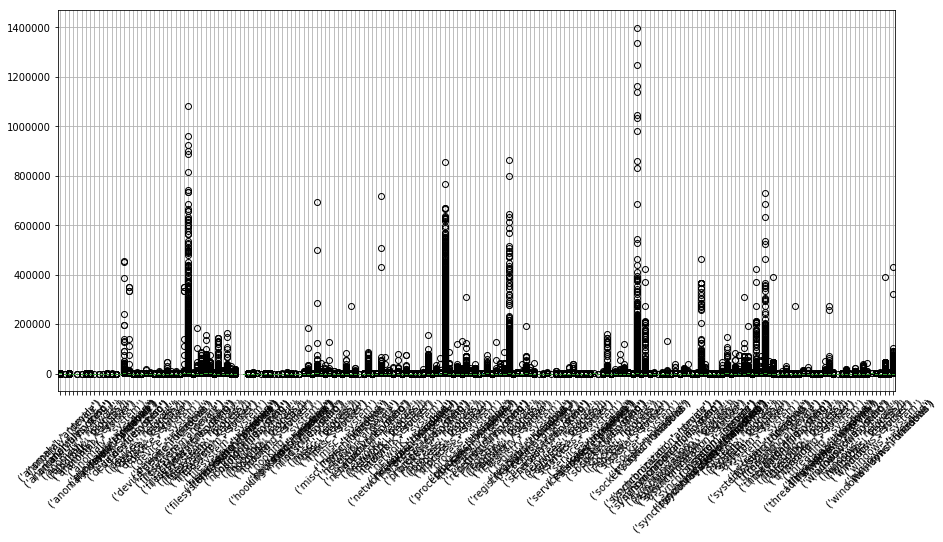

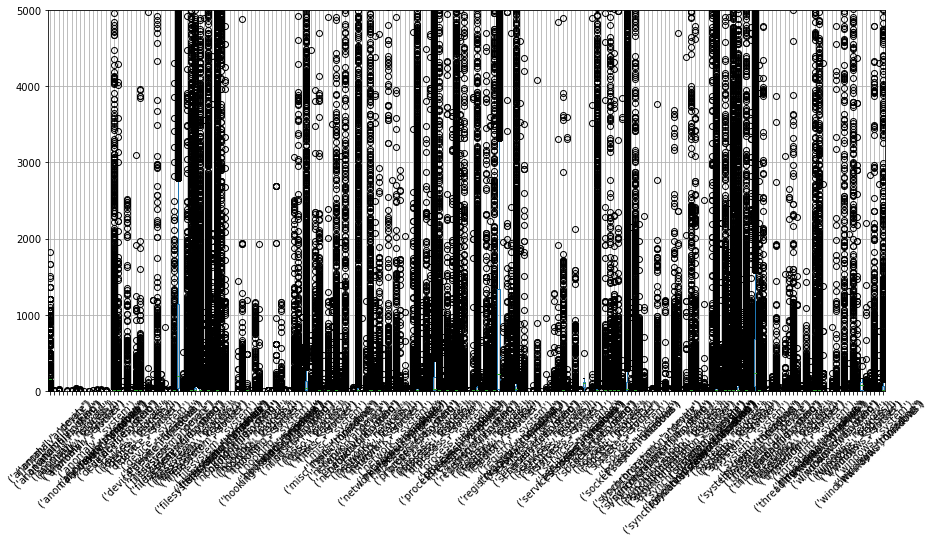

In [9]:
df.boxplot(figsize=(15,7), rot=45)
plt.show()
df.boxplot(figsize=(15,7), rot=45)
plt.ylim(-1, 5000)
plt.show()

In [11]:
rescaledX = QuantileTransformer(output_distribution='normal').fit_transform(df.fillna(0))
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(rescaledX)

In [12]:
learn_ready = pd.DataFrame(rescaledX, index=df.index, columns=df.columns)
learn_ready.loc[learn_ready.index.isin(goodware), 'malware'] = 0
learn_ready.loc[learn_ready.index.isin(malware_detailed.index), 'malware'] = 1
learn_ready.malware = learn_ready.malware.astype(bool)
learn_ready.to_csv(build_path('learn_behav_categories_bigrams'), compression='gzip')

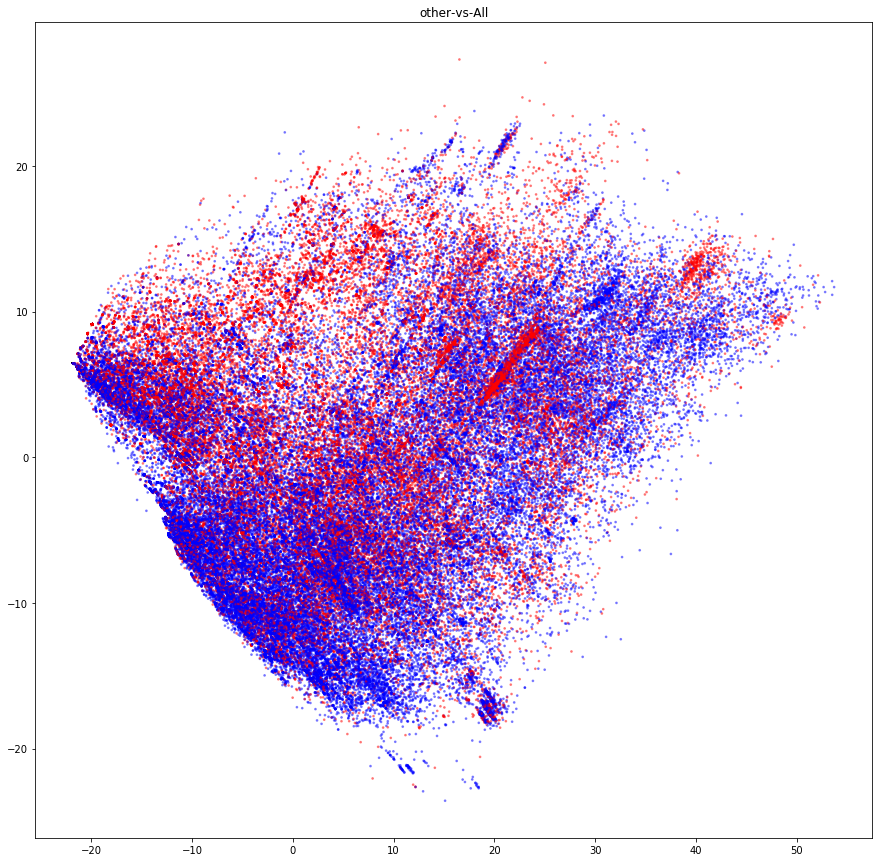

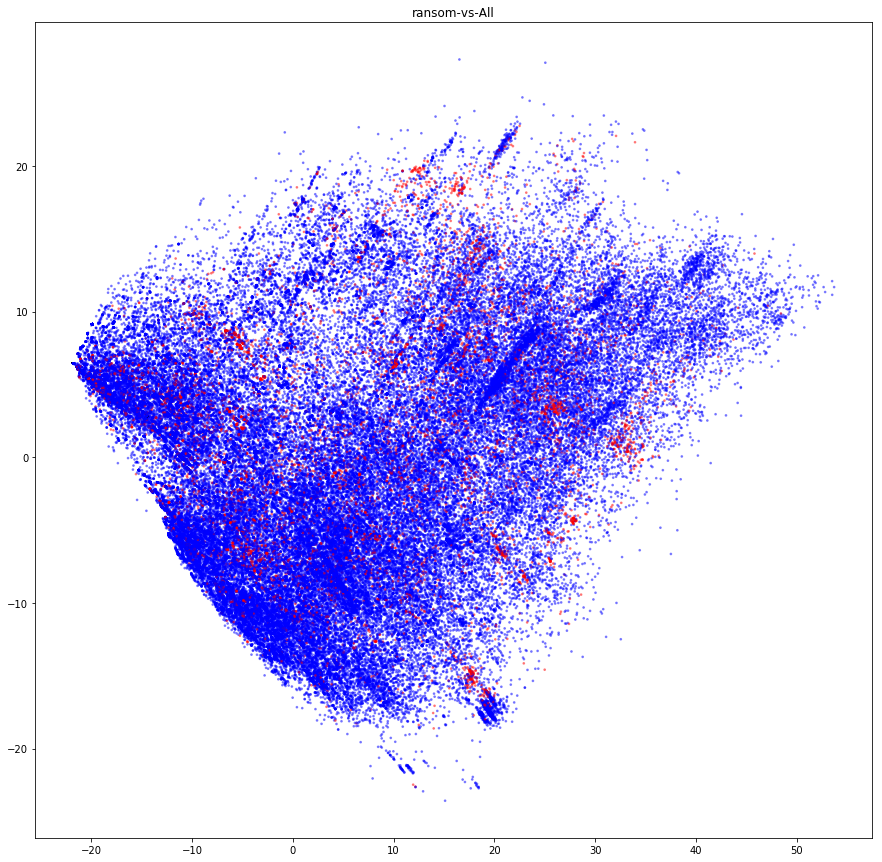

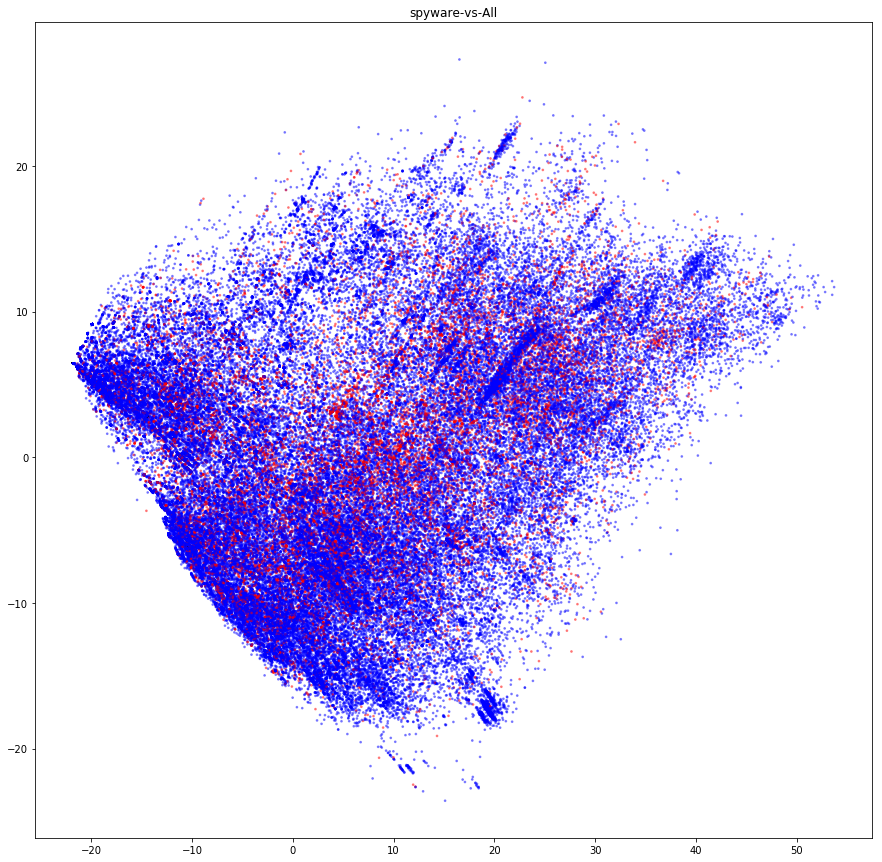

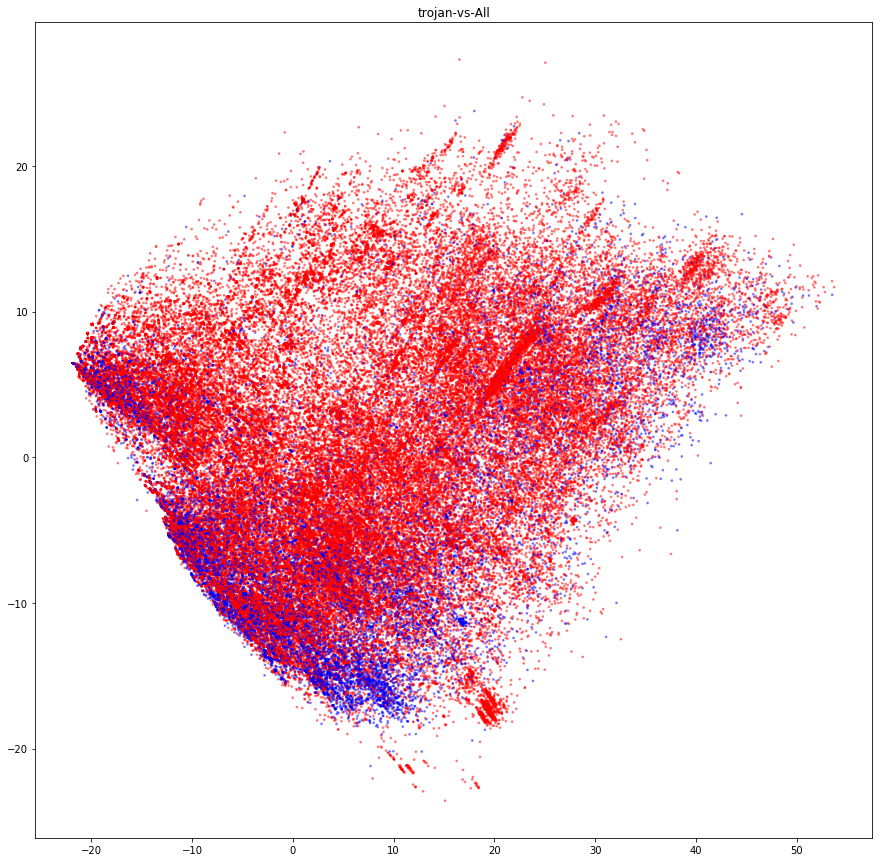

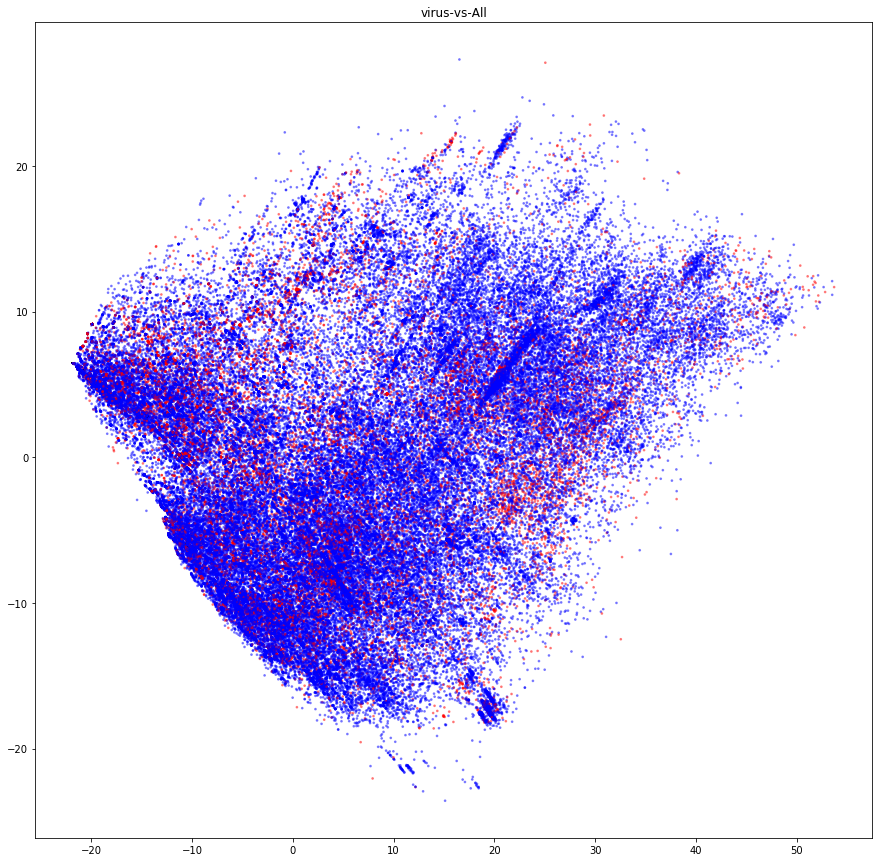

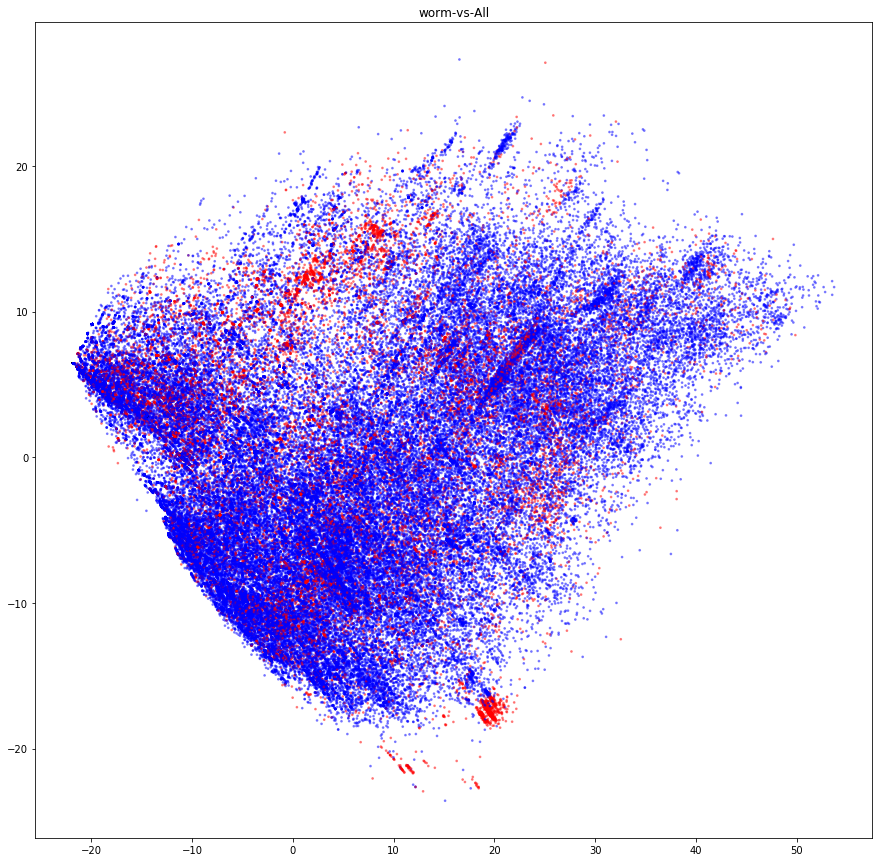

In [13]:
temp = pd.DataFrame(df.index).set_index('link')
for mal_type in malware_detailed.columns:
    malware = malware_detailed[mal_type].dropna()
    temp.loc[:, 'malware'] = 0
    temp.loc[temp.index.isin(malware.index), 'malware'] = 1
    
    plt.figure(figsize=(15, 15))
    plt.scatter(reduced_data[:,0], reduced_data[:,1], c=temp.malware, cmap='bwr', s=3, alpha=0.4)
    plt.title('{}-vs-All'.format(mal_type))
    plt.show()

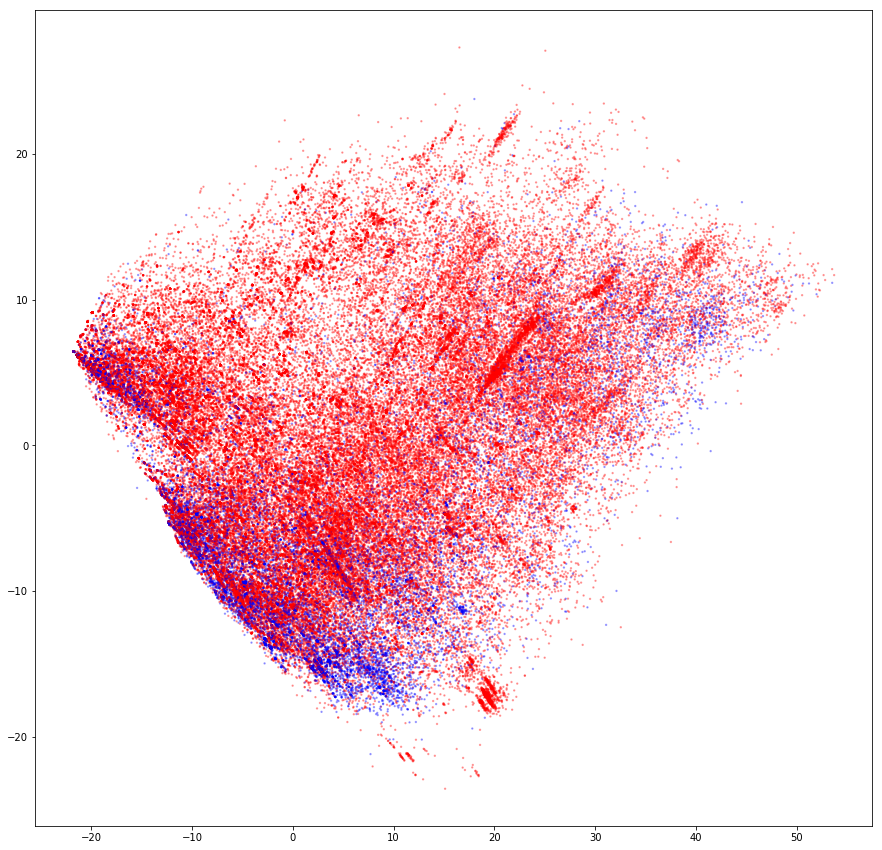

In [14]:
temp = pd.DataFrame(df.index).set_index('link')
temp.loc[:, 'malware'] = 1
temp.loc[temp.index.isin(goodware)] = 0
plt.figure(figsize=(15, 15))
plt.scatter(reduced_data[:,0], reduced_data[:,1], c=temp.malware, cmap='bwr', s=2, alpha=0.3)
plt.show()